<p> The details of the Kaggle contest in question are at https://www.kaggle.com/c/tweet-sentiment-extraction/overview. In this notebook, we attempt to pre-process input datasets to prepare them for NLP modelling. Input tweet sequences are cleaned and tokenized, and then wrapped in a BERT embedding for contextual awareness. Output text sequences are merely tokenized on an external library given the need to preserve sentence phrases. A local BERT client is used to generate the datasets. To run BERT locally, <br\><br/>
<i>
pip install bert-serving-server <br/>
pip install bert-serving-client <br/>
wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip
<br/>
bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 100
</i>
<p>

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn.metrics
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras as keras
from bert_serving.client import BertClient
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk.probability
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Conv1D, MaxPooling1D, RNN, Bidirectional

In [2]:
data = pd.read_csv("./data/train.csv")
testdata = pd.read_csv("./data/test.csv")
data.dropna(how="any", inplace=True)

Since the evaluation of modelling is on a word-level Jaccard score, we need to preserve spacing and punctuation. However, to improve BERT accuracy and trainY vocabulary indexing, we shall perform cleaning, and recover original punctuation after model prediction with a character-level input string comparison.

In [3]:
def cleaner(sent):
    #Tokenize web-links and space out punctuation for vocabulary creation
    sent = " ".join(np.vectorize(lambda s:"WEBSITE" if "http" in s else s)(np.array(sent.split())))
    sent = re.sub("[!.?:;,`]", " ", sent)
    return sent.lower()
for col in ['text','selected_text']:
    data[col] = data[col].apply(lambda s: cleaner(s))
testdata['text'] = testdata['text'].apply(lambda s: cleaner(s))
data = data.loc[data.text.apply(lambda s: len(s))!=1]

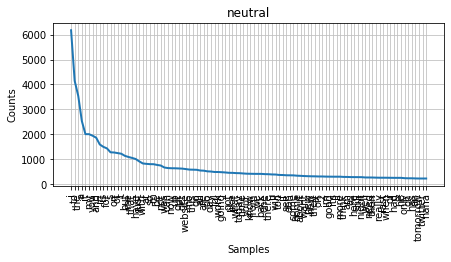

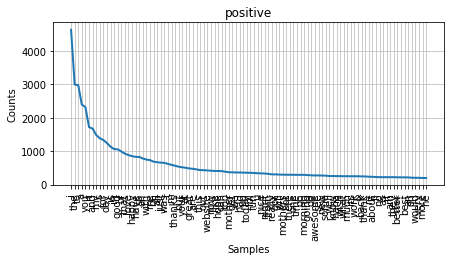

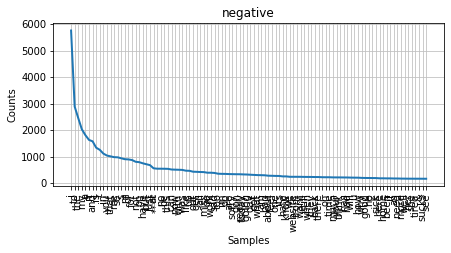

In [4]:
#Explore word frequencies for each sentiment
for label in data['sentiment'].value_counts().index:
    words = data.loc[data['sentiment']==label,"text"].values
    plt.figure(figsize=(7,3))
    plt.title(label)
    nltk.probability.FreqDist([token for row in words for token in row.split()]).plot(100)
    plt.show()

Given varied word frequency distributions, we can attempt different models for each sentiment label. Thus, independent word embeddings and model architectures are attempted on each of the positive, negative, and neutral labels. Since the sentiment is a parameter available before prediction, this design does not introduce data leakage.

<h2> Individual Label Datasets </h2>

In [7]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='\n', lower=True, split=' ', 
                                                   char_level=False, oov_token=None, document_count=0)
tokenizer.fit_on_texts(data['text'].values)
progress = pd.DataFrame(index=data.sentiment.value_counts().index, columns=['TrainX','TrainY','TestX'])
for sent in data.sentiment.value_counts().index:
    print("Entering Sentiment "+sent)
    #BERT-encode training set
    bc = BertClient()
    trainX = bc.encode(data.loc[data.sentiment==sent, "text"].to_list())
    #We set a null-padded tockenized array of size equivalent to longest tweet for label as the output sequence
    maxlen = data.loc[data.sentiment==sent, "text"].apply(lambda s: len(s.split())).max()
    trainY = tokenizer.texts_to_sequences(data.loc[data.sentiment==sent, "selected_text"])
    trainY = keras.preprocessing.sequence.pad_sequences(trainY, maxlen=maxlen, padding="post", value=0)
    #Encode test set
    testX = bc.encode(testdata.loc[testdata.sentiment==sent, "text"].to_list())
    #Save data artifacts for modelling pipeline
    pickle.dump(trainX, open("./data/"+sent+"trainX.pkl", "wb"))
    pickle.dump(trainY, open("./data/"+sent+"trainY.pkl", "wb"))
    pickle.dump(testX, open("./data/"+sent+"testX.pkl", "wb"))
    progress.loc[sent] = [trainX.shape, trainY.shape, testX.shape]

Entering Sentiment neutral
Entering Sentiment positive
Entering Sentiment negative


In [8]:
progress

,TrainX,TrainY,TestX
neutral,"(11116, 768)","(11116, 34)","(1430, 768)"
positive,"(8582, 768)","(8582, 34)","(1103, 768)"
negative,"(7781, 768)","(7781, 33)","(1001, 768)"


In [ ]:
#Tensorflow Jaccard Loss
def jaccard_loss(y_true, y_pred):
    def value(ten):
        if not ten.shape[0]: return 0
        sliceval = int(ten.shape[0]/2)
        x = tf.cast(tf.slice(ten,[0],[sliceval]), dtype=tf.int32)
        y = tf.cast(tf.slice(ten,[sliceval],[sliceval]), dtype=tf.int32)
        common = tf.sets.intersection(tf.reshape(y[y!=0],[1,-1]), tf.reshape(x[x!=0],[1,-1])).values
        x = tf.unique_with_counts(x[x!=0])[0]
        y = tf.unique_with_counts(y[y!=0])[0]
        if None in [common.shape[0], x.shape[0], y.shape[0]]: return 0
        if x.shape[0]==0 and y.shape[0]==0: return 1
        return common.shape[0]/(x.shape[0]+y.shape[0]-common.shape[0])
    var = tf.concat([tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, dtype=tf.float32)], axis=-1)
    return -tf.math.reduce_sum(tf.map_fn(value, var))

In [ ]:
#Tensorflow BERT Loss
def bert_loss(y_true, y_pred):
    bc = BertClient()
    def bert(arr):
        bc.encode([" ".join([tokenizer.index_word.get(i," ") for i in arr])])[0]
    y_pred = tf.map_fn(bert, tf.cast(y_pred, dtype=tf.int32))
    y_true = tf.map_fn(bert, y_true)
    return tf.math.reduce_sum((y_true-y_pred)**2)

In [ ]:
#Dense ANN
def dense_mdl(nunits=200, l2reg=0.05, drp=0.05, activation="relu", layers=1):
    model = Sequential()
    for _ in range(layers):
        model.add(Dense(nunits, kernel_regularizer=keras.regularizers.l2(l2reg), activation=activation,
                        bias_regularizer=keras.regularizers.l2(l2reg)))
    model.add(Dropout(drp))
    model.add(Dense(postrainY.shape[1], kernel_regularizer=keras.regularizers.l2(l2reg),
                    bias_regularizer=keras.regularizers.l2(l2reg), activation=activation))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4), loss=jaccard_loss)
    return model